Yield stagnation in staple crops such as wheat, sorghum, rice, and corn is a growing concern in global agriculture. After decades of yield improvements due to the Green Revolution, crop yields have begun to plateau in many regions. The yield gap analysis quantifies the difference between potential and actual farm yields, identifying how much room there is for improvement. By analyzing the yield gap, researchers and policymakers can pinpoint specific factors limiting crop performance, whether they be agronomic, genetic, or socio-economic, and target practices or interventions to harness the remaining exploitable yield to ensure food security.

In this exercise we will use a dataset of historical sorghum grain yield for the state of Kansas obtained from farmer surveys (Source: United States Department of Agriculture National Agricultural Statistics Service). The dataset spans the period from 1929 until 2023 and includes multiple drought events. The goals of this exercise are to: 1) fit a piece-wise linear model to different periods to quantify yield trends that could reveal signs of yeld stagnation and 2) quantify yield variability over time to detect whether state-level grain yield is becoming more irregular over time.


In [575]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import piecewise_regression # !pip install piecewise_regression


## Read, convert units, and explore dataset

In [580]:
# Read dataset
df = pd.read_csv('../datasets/sorghum_yield_kansas.csv')

# Retain only coluns for year and yield value
df = df[['Year','Value']]

# Rename columns
df.rename(columns={'Year':'year', 'Value':'yield_bu_ac'}, inplace=True)

# Display a few rows
df.head()


,year,yield_bu_ac
0,2023,52.0
1,2022,39.0
2,2021,78.0
3,2020,85.0
4,2019,85.0


In [581]:
# Convert units (39.368 bu per Mg and 0.405 ac per hectare)
df['yield_mg_ha'] = df['yield_bu_ac']/0.405/39.368
df.head(3)


,year,yield_bu_ac,yield_mg_ha
0,2023,52.0,3.261407
1,2022,39.0,2.446055
2,2021,78.0,4.892110


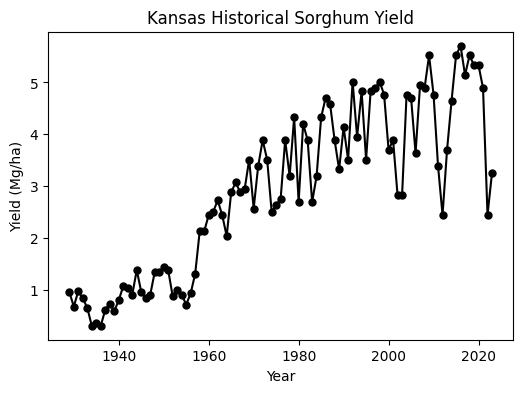

In [582]:
# Visualize dataset
plt.figure(figsize=(6,4))
plt.title('Kansas Historical Sorghum Yield')
plt.plot(df['year'], df['yield_mg_ha'], color='k', marker='o', markersize=5)
plt.xlabel('Year')
plt.ylabel('Yield (Mg/ha)')
plt.show()


## Yield trend

To synthesize the main yield trends we will subdivide the time series into periods. We know in advance that sorghum hybrids, which have higher yield potential than tradional varieties due to heterosis or hybrid vigor, were introduced in the 1950s. This also coincides with the widespread use of fertilizers. There is also some evidence, from crops like winter wheat, that yields started to show signs of stagnation around 1980s. So, with these tentative years in mind and some visual inspection we will define two breakpoints to start.

In [614]:
# Define year breaks based on visual inspection
sections = [{'start':1929, 'end':1955, 'ytxt':1.5},
            {'start':1955, 'end':1990, 'ytxt':1.0},
            {'start':1990, 'end':2023, 'ytxt':0.5}]


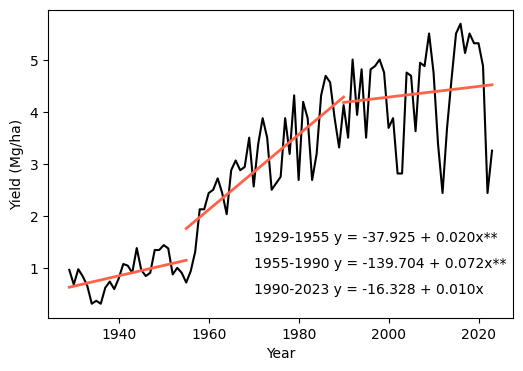

In [615]:
# Fit linear models and create figure

plt.figure(figsize=(6,4))
plt.plot(df['year'], df['yield_mg_ha'], '-k')

for k,s in enumerate(sections):
    
    # Select period
    idx = (df['year']>= s['start']) & (df['year']<= s['end'])
    
    # Put X and y variables in shorter names and proper format
    x = df.loc[idx,'year'].values
    y = df.loc[idx,'yield_mg_ha'].values
    
    # Linear regresion using OLS
    slope, intercept, r, p, se = linregress(x, y)

    # Plot line
    y_pred = intercept+slope*x
    plt.plot(x, y_pred, color='tomato', linewidth=2)

    # Add annotations to chart
    if p<0.01:
        sig = '**'
    elif p<0.05:
        sig='*'
    else:
        sig = ''
        
    # Annotate the chart
    txt = f"{s['start']}-{s['end']} y = {intercept:.3f} + {slope:.3f}x{sig}"
    plt.text(1970, s['ytxt'], txt)
    #plt.text(1928, 5.3, 'A', size=20)

plt.xlabel('Year')
plt.ylabel('Yield (Mg/ha)')
plt.show()


## Optimize breakpoints

A more formal analysis could be done by using a library that optimizes the breakpoints. The `piecewise-regression` library, which is built-in on top of the `statsmodels` library is a good option to find breakpoints.


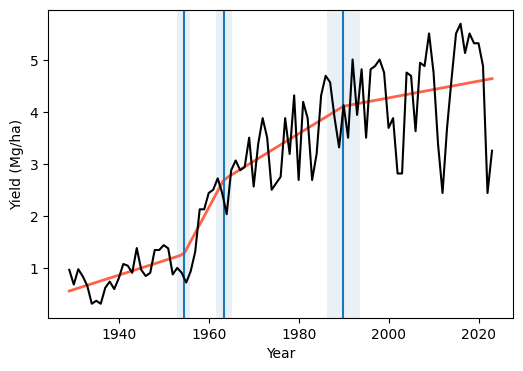

In [623]:
# Get Numpy arrays for x and y variables
x = df['year'].values

# Compute decadal moving average to smooth extreme yield oscillations
y_mov_mean = df['yield_mg_ha'].rolling(window=10,
                                       center=True,
                                       min_periods=5).mean().values

# Fit piecewise model (here you can try multiple breakpoints
pw_fit = piecewise_regression.Fit(x, y_mov_mean, n_breakpoints=3)

# Create figure to visualize breakpoints
plt.figure(figsize=(6,4))
#pw_fit.plot_data(color="grey", s=20)
pw_fit.plot_fit(color="tomato", linewidth=2)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.plot(df['year'], df['yield_mg_ha'], '-k')
plt.xlabel('Year')
plt.ylabel('Yield (Mg/ha)')
plt.show()


Smoothing the time series using a decadal moving average and then fitting a piecewise linear model using three breakpoints instead of two revealed the sharp yield increase in the late 1950s and early 1960s when sorghum hybrids were introduced into the market, and two additional segments showing the gradual increase in grain yield, but with decreasing slopes, signaling a potential yield stagnation of sorghum yields across Kansas.

## Yield variance

While the exact breaks for the linear regression can be debatable, one aspect that seems clear in this dataset is the increasing variance of grain yields. One possible reason could be the increased temporal variability of environmental variables directly related to grain yield, like growing season precipitation. This is clearly seen in later decades, where state-level yiedlds have declined dramatically. Another possible reason for the increasing yield variability could be the shifting of sorghum planted area, from wetter to drier portions of the state. But the specific reason, whether due to climatological or geographical factors, remains to be explored.


### De-trending yield

One way to visualize yield variation over time is to plot the detrended time series.

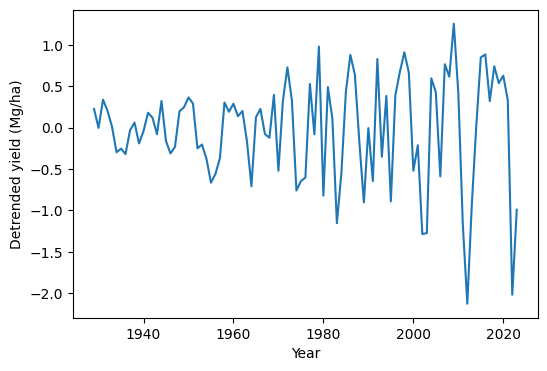

In [571]:
# Subtract piecewise linear model from yield time series
yield_detrended = df['yield_mg_ha'] - pw_fit.yy

# Create figure
plt.figure(figsize=(6,4))
plt.plot(df['year'], yield_detrended)
plt.xlabel('Year')
plt.ylabel('Detrended yield (Mg/ha)')
plt.show()


### Moving variance

Another option to visualize the variance of a time series is to compute the moving variance.

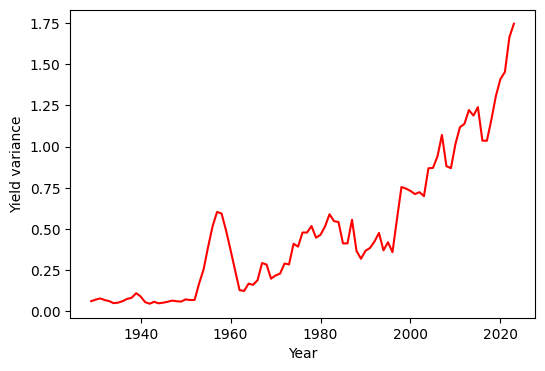

In [573]:
# Moving variance
mov_var = df['yield_mg_ha'].rolling(window=10,center=True,min_periods=1).var()

# Create figure
plt.figure(figsize=(6,4))
plt.plot(df['year'], mov_var, color='r')
plt.xlabel('Year')
plt.ylabel('Yield variance')
plt.show()
